<a href="https://colab.research.google.com/github/MateoGonzalez/text-analytics-project/blob/main/Text_Analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Imports

In [16]:
import pandas as pd
import numpy as np
import os
import gc

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# set a seed value
torch.manual_seed(555)

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report

!pip install transformers
import transformers
from transformers import BertTokenizer, BertForSequenceClassification 
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW
from transformers import AutoModel, BertTokenizerFast

import warnings
warnings.filterwarnings("ignore")


print(torch.__version__)

1.7.0+cu101


In [3]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk import sent_tokenize
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Functions

In [ ]:
# this function allow to load a df from google drive
import os
import sys
from google.colab import drive

def load_df(path, name):
  drive.mount('/content/drive',force_remount=True)
  project_dir = path

  os.chdir(project_dir)
  df = pd.read_csv(project_dir + name)
  return df

In [ ]:
# this function take two columns of a dataframe and return a list of their concatenation
def concatenate_sentences(col_1, col_2):
  sentences= list()

  for i in range( 0, len(col_1) ):
    sentences.append( col_1[i] + col_2[i] )

  return sentences

# example
#list_of_sentences= concatenate_sentences(df['premise'],df['hypothesis'])
#list_of_sentences

In [ ]:
# this function take a list of sentences, then it return the right input for word embending model
def prepare_input_we(sentences):
  tok_sents= list()

  for sentence in sentences:
    tok_sents.append(word_tokenize(sentence))
  
  return tok_sents

# example
#tok_sents= prepare_input_we(list_of_sentences)

In [ ]:
# this function takes a list of sentences and return the right input for doc2vec model
def prepare_input_w2d(list_of_sentences):
  return [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(list_of_sentences)]

In [3]:
class TokensTensors(Dataset):

    def __init__(self, df):
        self.df_data = df



    def __getitem__(self, index):

        # get the sentence from the dataframe
        sentence1 = self.df_data.loc[index, 'premise']
        sentence2 = self.df_data.loc[index, 'hypothesis']

        # Process the sentence
        # ---------------------

        encoded_dict = tokenizer.encode_plus(
                    sentence1, sentence2,           # Sentences to encode.
                    add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                    max_length = MAX_LEN,           # Pad or truncate all sentences.
                    padding = True,
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt',          # Return pytorch tensors.
                    truncation=True
               )  
        
        # These are torch tensors already.
        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        token_type_ids = encoded_dict['token_type_ids'][0]
        
        
        if 'label' in self.df_data.columns:
          # Convert the target to a torch tensor
          target = torch.tensor(self.df_data.loc[index, 'label'])

          sample = (padded_token_list, att_mask, token_type_ids, target)
        else:
          sample = (padded_token_list, att_mask, token_type_ids)

        return sample


    def __len__(self):
        return len(self.df_data)

# Obtain data

In [4]:
train_df_orig = pd.read_csv('https://raw.githubusercontent.com/MateoGonzalez/text-analytics-project/main/train.csv')
test_df_orig = pd.read_csv('https://raw.githubusercontent.com/MateoGonzalez/text-analytics-project/main/test.csv')

In [4]:
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


# Exploratory Data Analysis

In [6]:
print("train: ", train_df.shape)
print("test: ", test_df.shape)

train:  (12120, 6)
test:  (5195, 5)


In [ ]:
train_df.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'], dtype='object')

In [7]:
test_df.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language'], dtype='object')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


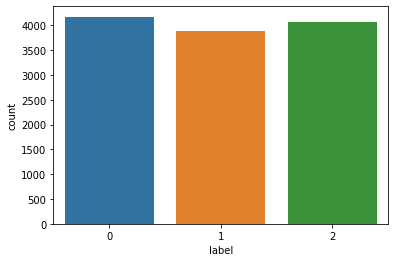

In [ ]:
sns.countplot(train_df['label'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


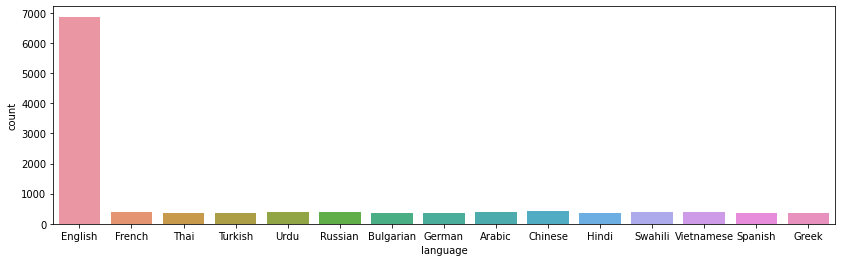

In [ ]:
plt.figure(figsize=(14,4))
sns.countplot(train_df['language'])

# Assesing data quality

In [ ]:
## Is there any duplicated line?
train_df[train_df.duplicated()].count()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

# Data preparation

## Data Tweaks 

We decided to work only with english sentences.

In [5]:
train_df=train_df_orig[train_df_orig['lang_abv']== 'en'].copy()
test_df=test_df_orig[test_df_orig['lang_abv']== 'en'].copy()

#print( eng_train['lang_abv'].unique() )
#print( eng_test['lang_abv'].unique() )

In [6]:
COLUMNS_TO_DROP= ['id', 'lang_abv', 'language']

for col in COLUMNS_TO_DROP:
  train_df.drop(columns= col, inplace= True)
  test_df.drop(columns= col, inplace= True)

## kFolds

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold

# initialize kfold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1024)

# Extract labels for stratification
X, y = train_df[["premise", "hypothesis"]], train_df['label']

# Each fold is a tuple ([train_index_values], [val_index_values])
# fold_0, fold_1, fold_2, fold_3, fold_5 = kf.split(df, y)

# Put the folds into a list. This is a list of tuples.
fold_list = list(kf.split(X, y))

train_df_list = []
val_df_list = []

for i, fold in enumerate(fold_list):

    # map the train and val index values to dataframe rows
    df_train = train_df[train_df.index.isin(fold[0])]
    df_val = train_df[train_df.index.isin(fold[1])]
    
    train_df_list.append(df_train)
    val_df_list.append(df_val)
    
    

print(len(train_df_list))
print(len(val_df_list))

5
5


In [8]:
# Display one train fold

train_df_list[0].head()

,premise,hypothesis,label
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0
7,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2
8,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1


## Word Embedding

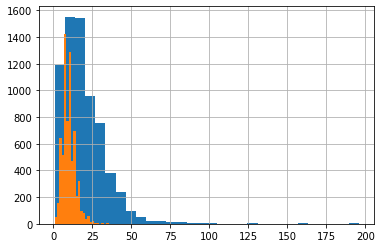

In [9]:
## Number of words in each premise and hypothesis sentences

premise_len = [len(i.split()) for i in train_df['premise']]
hypothesis_len = [len(i.split()) for i in train_df['hypothesis']]

for i in [premise_len,hypothesis_len]:
  pd.Series(i).hist(bins=30)

In [11]:
MODEL_TYPE = 'bert-base-uncased'


L_RATE = 1e-5
MAX_LEN = 25  ## We took into consideration mean sentence lenght from previous plot.
FOLDS = 5
NUM_EPOCHS = 3
BATCH_SIZE = 32
NUM_CORES = os.cpu_count()

print(NUM_CORES)

2


In [12]:
# For GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [13]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)
print('done!')

Loading BERT tokenizer...



done!


In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

train_data = TokensTensors(df_train)
val_data = TokensTensors(df_val)
test_data = TokensTensors(test_df)



train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                       num_workers=NUM_CORES)



print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

98
25
93


In [21]:
# Get one train batch

padded_token_list, att_mask, token_type_ids, target = next(iter(train_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

torch.Size([32, 25])
torch.Size([32, 25])
torch.Size([32, 25])
torch.Size([32])


### To verify.

In [ ]:
# i load my dataset because the eng_train doesn't work here and i don't know why
PATH= '/content/drive/My Drive/TA/'
df= load_df(PATH, 'eng_train.csv')
df.drop(columns='Unnamed: 0', inplace= True)

Mounted at /content/drive


In [ ]:
list_of_sentences= concatenate_sentences( df['premise'], df['hypothesis'] )
tagged_data = prepare_input_w2d(list_of_sentences)
model = Doc2Vec(tagged_data, vector_size=250, window=5, min_count=10, epochs= 50)

2020-12-27 18:04:17,177 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-12-27 18:04:17,180 : INFO : collecting all words and their counts
2020-12-27 18:04:17,183 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-12-27 18:04:17,238 : INFO : collected 16817 word types and 6870 unique tags from a corpus of 6870 examples and 215929 words
2020-12-27 18:04:17,238 : INFO : Loading a fresh vocabulary
2020-12-27 18:04:17,250 : INFO : effective_min_count=10 retains 2367 unique words (14% of original 16817, drops 14450)
2020-12-27 18:04:17,251 : INFO : effective_min_count=10 leaves 177774 word corpus (82% of original 215929, drops 38155)
2020-12-27 18:04:17,260 : INFO : deleting the raw counts dictionary of 16817 items
2020-12-27 18:04:17,261 : INFO : sample=0.001 downsamples 58 most-common words
2020-12-27 18:04:17,261 : INFO : downsampling leaves estimated 119554 word corpus (67.3% of prior 177774)
2020-12-27 18:04:17,27

In [ ]:
#list_of_sentences= concatenate_sentences( eng_train['premise'], eng_train['hypothesis'] )
#tagged_data = prepare_input_w2d(list_of_sentences)
#model = Doc2Vec(tagged_data, vector_size=250, window=5, min_count=10, epochs= 50)

KeyError: ignored

# Classic Machine Learning Classification

# BERT Classification

In [13]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 51kB 6.5MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30537 sha256=0c062f0726bf0af2f9829c1db013f15a411426003d9350bc90f726235b9ee45f
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7303 sha256=b60b7990a812fdb989a37f0c94c625c6d62fe0cda5d54e9e21d0b0a8f6e371dd
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19474 sha256=a82d87ad6271e1e75f9264875a664bd97aef3660ae3195827c5f153d9b863a3e
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.1MB 9.2MB/s 


In [17]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

2.4.0


## Model Definition

In [17]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(MODEL_TYPE)


In [18]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [19]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [21]:

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = L_RATE)          # learning rate

In [32]:
 enumerate(train_dataloader)

In [27]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_predsa

In [28]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [29]:
epochs = NUM_EPOCHS
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3


RuntimeError: ignored

In [24]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE, 
    num_labels = 3, 
    output_attentions = False,
    output_hidden_states = False)

# Send the model to the device.
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
# Get one train batch

train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=8,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

batch = next(iter(train_dataloader))

b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_token_type_ids = batch[2].to(device)
b_labels = batch[3].to(device)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [26]:
outputs = model(b_input_ids, 
                token_type_ids=b_token_type_ids, 
                attention_mask=b_input_mask,
                labels=b_labels)

In [27]:
outputs

SequenceClassifierOutput([('loss',
                           tensor(1.1779, device='cuda:0', grad_fn=<NllLossBackward>)),
                          ('logits', tensor([[ 0.4013, -0.0353, -0.1948],
                                   [ 0.5057, -0.2213, -0.3892],
                                   [ 0.4056, -0.2278, -0.3850],
                                   [ 0.1799,  0.2544, -0.0730],
                                   [ 0.4171, -0.2556, -0.4248],
                                   [ 0.4508, -0.2361, -0.4016],
                                   [ 0.4249, -0.2569, -0.4329],
                                   [ 0.4396, -0.2416, -0.4222]], device='cuda:0', grad_fn=<AddmmBackward>))])

In [28]:
preds = outputs[1].detach().cpu().numpy()

y_true = b_labels.detach().cpu().numpy()
y_pred = np.argmax(preds, axis=1)

y_pred

array([0, 0, 0, 1, 0, 0, 0, 0])

In [38]:
# This is the accuracy without any fine tuning.

val_acc = accuracy_score(y_true, y_pred)

val_acc

0.375


Num folds used for training: 3
======== Epoch 1 / 3 ========

== Fold Model 0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training...


TypeError: ignored